In [1]:
using Plots
using SpecialFunctions
gr();

In [2]:
# Cubic spline solver, defaults to free boundary conditions
function cspl(; data, bc="free")
    xx, yy = map(y -> map(x -> x[y], data), 1:2)
    
    # number of splines, number of interior points, etc
    nsp = length(xx) - 1
    inter = nsp - 1
    n = 2*nsp

    # Initialize a matrix
    m = zeros(2*n, 2*n)

    # Partition the columns into sets of four
    p = [4*(j-1) .+ [i for i in 1:4] for j in 1:nsp]
    
    # Construct the solution vector
    zz = fill(0.0, 2*n)
    zz[1] = yy[1]
    zz[n] = yy[end]
    for i in 2:inter+1
        j = 2*(i-2) .+ [1,2]

        zz[j[1]+1] = yy[i]
        zz[j[2]+1] = yy[i]
    end
    
    # s, s', s'' coefficients
    coefs = [[1,1,1,1], [0,1,2,3], [0,0,2,6]]
    exps = [[0,1,2,3], [0,0,1,2], [0,0,0,1]]

    # s, s', s'' general forms as lambda expressions
    s = [x -> coefs[1][j]*(x-xi)^exps[1][j] for xi in xx[1:end-1], j in 1:4]
    ds = [x -> coefs[2][j]*(x-xi)^exps[2][j] for xi in xx[1:end-1], j in 1:4]
    dds = [x -> coefs[3][j]*(x-xi)^exps[3][j] for xi in xx[1:end-1], j in 1:4]
    
    # store s, s', s'' in a single matrix
    s = vcat(s, vcat(ds, dds))

    # Evaluate spline lambdas at a given x value
    function seval(s, x)
        return [round(f(x), digits=5) for f in s]
    end

    # this loop fills in the first 2*(number of splines) rows
    # where each pair of rows corresponds to a single spline
    # evaluated at its two end points
    j=1
    for i in 1:2:n
        j = mod1(j, nsp)
        m[i, p[j]] = seval(s[j,:], xx[j])
        m[i+1, p[j]] = seval(s[j,:], xx[j+1])
        j += 1
    end

    # this loop fills in the next 2*(number of interior points) rows
    # where each row consists of the first derivatives of adjacent splines
    # evaluated at the boundary between the two splines
    # and each row after the all the first derivatives then evaluates
    # all of the second derivatives
    for i in 1:inter
        q = mod1(i, nsp)

        # s' is evaluated at each spline transition
        # the second 'seval' is negative which corresponds to
        # subtracting the (i+1)th spline on the (i)th spline's side
        m[i+n, p[q]] = seval(s[i+nsp,:], xx[i+1])
        m[i+n, p[q+1]] = -seval(s[i+nsp+1,:], xx[i+1])

        # s'' is evaluated at each spline transition
        m[i+n+inter, p[q]] = seval(s[i+n,:], xx[i+1])
        m[i+n+inter, p[q+1]] = -seval(s[i+n+1,:], xx[i+1])
    end

    if bc == "free"
        # Free boundary conditions
        m[end-1, p[1]] = seval(s[1+n,:], xx[1]) 
        m[end, p[end]] = seval(s[3*nsp,:], xx[end])
    elseif bc == "nk"
        # Not-a-knot boundary conditions
        m[end-1,:] = vcat([0, 0, 0, 6, 0, 0, 0, -6], fill(0.0, 2*n-8))
        m[end,:] = vcat(fill(0.0, 2*n-8), [0, 0, 0, 6, 0, 0, 0, -6])
    else
        println("please specify valid boundary conditions!")
        return 0,0
    end

    # Solve for the coefficients
    z = m\zz
    
    # Partition coefficients into sets of four
    z =  [[z[4*(j-1)+i] for i in 1:4] for j in 1:nsp]
    soln = []

    # Construct the splines with the given coefficients
    # then tore the splines in a vector to return
    for i in 1:length(z)
        push!(soln, x -> sum(z[i][j]*(x-xx[i])^(j-1) for j in 1:4))
    end

    return soln
end;

In [3]:
# Newton's divided difference polynomial
function ndd(; data)
    n = length(data)
    # initialize nxm matrix
    m = zeros(Float64, n, n)
    
    # unzips list of (x,y) coords into separate lists
    # set first column of DD matrix to f(x) for x in xx
    xx, m[:,1] = map(y -> map(x -> x[y], data), 1:2)

    # generate lower triangular NDD matrix
    for i in 2:n
        for j in 2:i
            m[i,j] = (m[i,j-1]-m[i-1,j-1])/(xx[i]-xx[i-j+1])
        end
    end
    
    # return a lambda in x: 
    # sum the diagonal entries as coefficients
    # on the generated Newton polynomial
    return x-> sum(m[i,i]*poly(i, x, xx) for i in 1:n), hcat(xx, m)
end


# Helper function to generate Newton polynomials
function poly(i, x, xx)
    p = 1
    for j in 1:i-1
        p *= (x-xx[j]) # (x - xj) for j from 1 to i-1
    end
    return p
end;

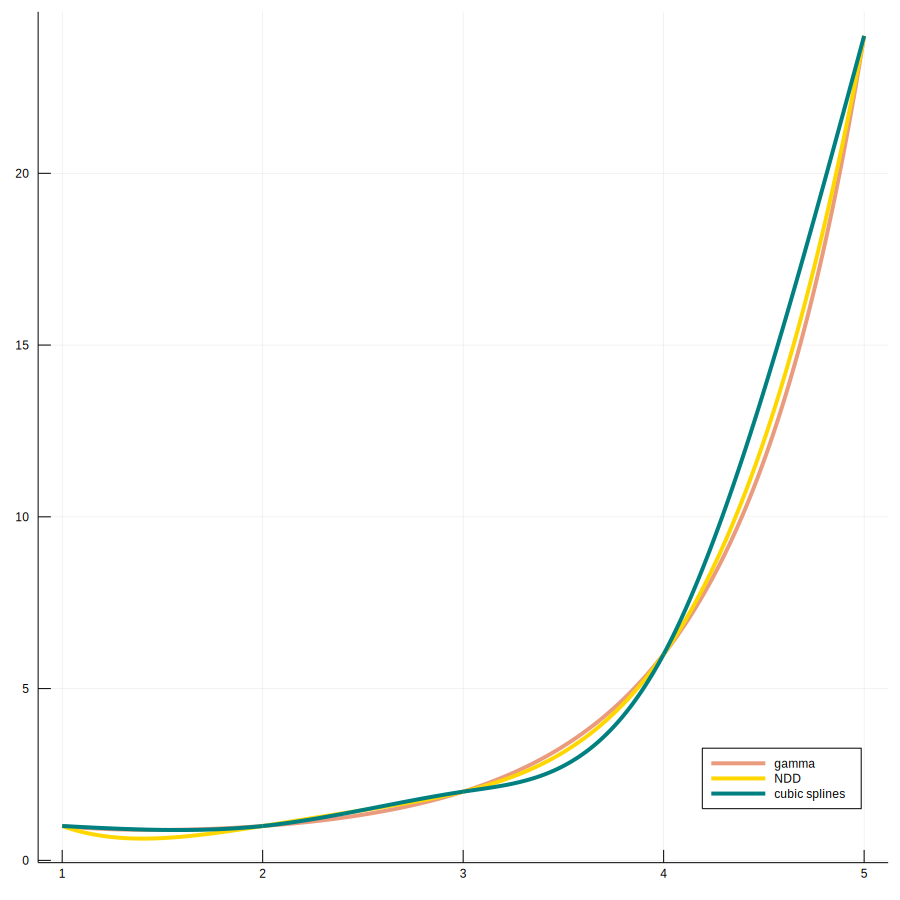

In [11]:
data = [(1,1), (2,1), (3,2), (4,6), (5,24)]

np, = ndd(data=data)
splines = cspl(data=data)

xx = collect(1:0.01:5)

s0, s1, s2, s3 = splines
x0 = collect(1:0.01:2)
x1 = collect(2:0.01:3)
x2 = collect(3:0.01:4)
x3 = collect(4:0.01:5)

p = plot([],[],label="",size=(900,900), legend=:bottomright)
plot!(p, xx, gamma.(xx), lw=4, alpha=0.7, label="gamma")
plot!(p, xx, np.(xx), lc=:gold, lw=4, label="NDD")
plot!(p, x0, s0.(x0), lc=:teal, lw=4, label="cubic splines")
plot!(p, x1, s1.(x1), lc=:teal, lw=4, label="")
plot!(p, x2, s2.(x2), lc=:teal, lw=4, label="")
plot!(p, x3, s3.(x3), lc=:teal, lw=4, label="")

# savefig(p, "gamma-fsplines-ndd")

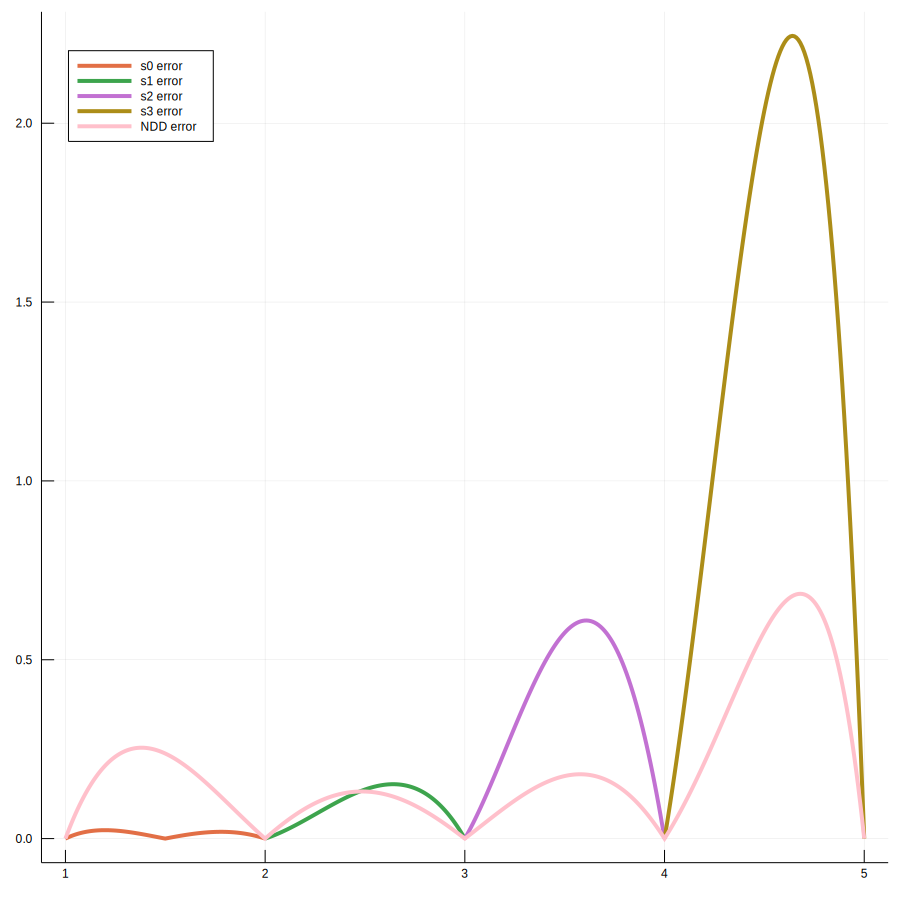

In [12]:
p = plot([],[],label="",size=(900,900), legend=:topleft)
plot!(p, x0, abs.(gamma.(x0)-s0.(x0)), lw=4, label="s0 error")
plot!(p, x1, abs.(gamma.(x1)-s1.(x1)), lw=4, label="s1 error")
plot!(p, x2, abs.(gamma.(x2)-s2.(x2)), lw=4, label="s2 error")
plot!(p, x3, abs.(gamma.(x3)-s3.(x3)), lw=4, label="s3 error")
plot!(p, xx, abs.(gamma.(xx)-np.(xx)), lc=:pink, lw=4, label="NDD error")

# savefig(p, "gamma-fsplines-ndd error")

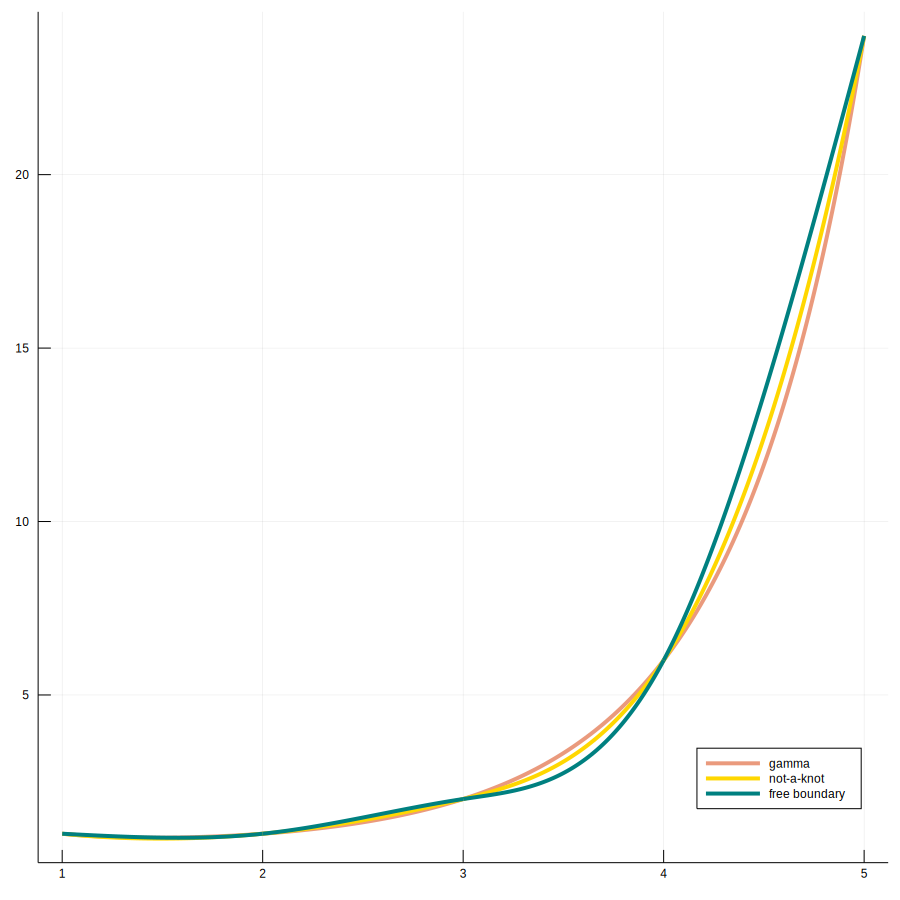

In [13]:
data = [(1,1), (2,1), (3,2), (4,6), (5,24)]

nksplines = cspl(data=data, bc="nk")
fsplines = cspl(data=data, bc="free")

f0, f1, f2, f3 = fsplines
nk0, nk1, nk2, nk3 = nksplines

xx = collect(1:0.01:5)
x0 = collect(1:0.01:2)
x1 = collect(2:0.01:3)
x2 = collect(3:0.01:4)
x3 = collect(4:0.01:5)

p = plot([],[],label="",size=(900,900), legend=:bottomright)
plot!(p, xx, gamma.(xx), lw=4, alpha=0.7, label="gamma")
plot!(p, x0, nk0.(x0), lc=:gold, lw=4, label="not-a-knot")
plot!(p, x1, nk1.(x1), lc=:gold, lw=4, label="")
plot!(p, x2, nk2.(x2), lc=:gold, lw=4, label="")
plot!(p, x3, nk3.(x3), lc=:gold, lw=4, label="")
plot!(p, x0, f0.(x0), lc=:teal, lw=4, label="free boundary")
plot!(p, x1, f1.(x1), lc=:teal, lw=4, label="")
plot!(p, x2, f2.(x2), lc=:teal, lw=4, label="")
plot!(p, x3, f3.(x3), lc=:teal, lw=4, label="")

# savefig(p, "gamma-nk-fb")

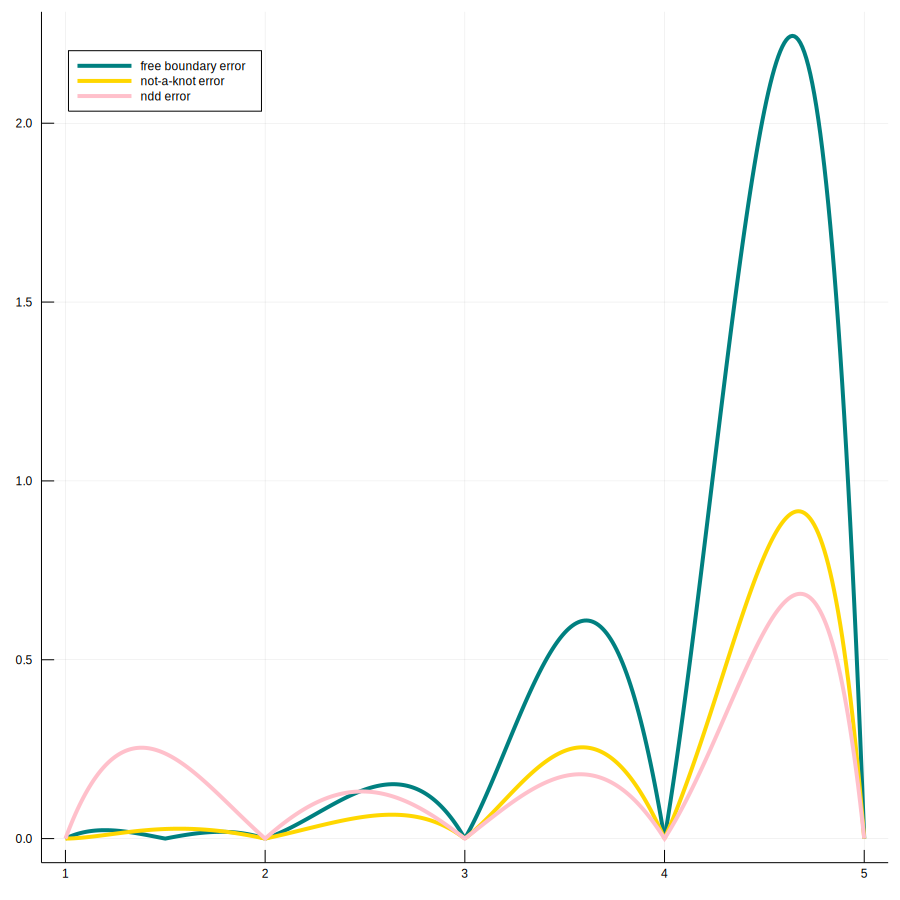

In [14]:
function err(f, x)
    return abs.(gamma.(x)-f.(x))
end

p = plot([],[],label="",size=(900,900), legend=:topleft)
plot!(p, x0, err(f0,x0), lc=:teal, lw=4, label="free boundary error")
plot!(p, x1, err(f1,x1), lc=:teal, lw=4, label="")
plot!(p, x2, err(f2,x2), lc=:teal, lw=4, label="")
plot!(p, x3, err(f3,x3), lc=:teal, lw=4, label="")
plot!(p, x0, err(nk0,x0), lc=:gold, lw=4, label="not-a-knot error")
plot!(p, x1, err(nk1,x1), lc=:gold, lw=4, label="")
plot!(p, x2, err(nk2,x2), lc=:gold, lw=4, label="")
plot!(p, x3, err(nk3,x3), lc=:gold, lw=4, label="")
plot!(p, xx, err(np,xx), lc=:pink, lw=4, label="ndd error")

# savefig(p, "fb-nk-ndd-error")

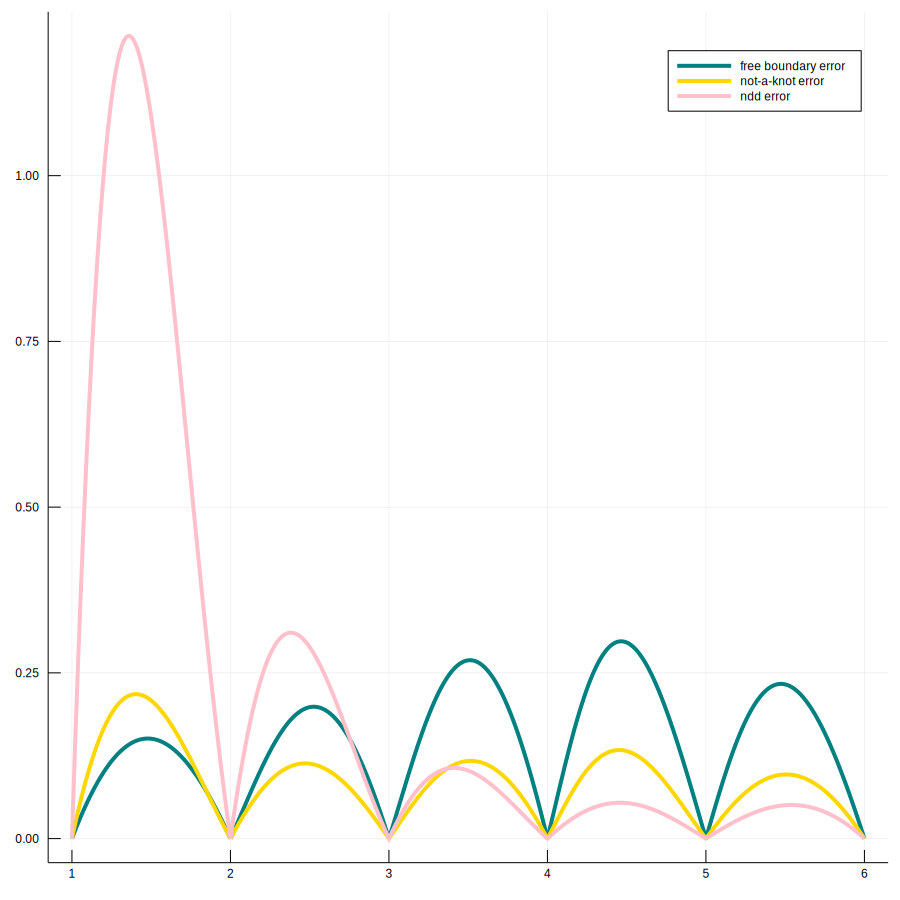

In [15]:
function rel_err(f, x)
    return abs.(gamma.(x)-f.(x))./(gamma.(x))
end


data = [(1,1), (2,1), (3,2), (4,6), (5,24), (6,120)]

np, = ndd(data=data)
nksplines = cspl(data=data, bc="nk")
fsplines = cspl(data=data, bc="free")

f0, f1, f2, f3, f4 = fsplines
nk0, nk1, nk2, nk3, nk4 = nksplines

xx = collect(1:0.01:6)
x0 = collect(1:0.01:2)
x1 = collect(2:0.01:3)
x2 = collect(3:0.01:4)
x3 = collect(4:0.01:5)
x4 = collect(5:0.01:6)

p = plot([],[],label="",size=(900,900), legend=:topright)
plot!(p, x0, rel_err(f0,x0), lc=:teal, lw=4, label="free boundary error")
plot!(p, x1, rel_err(f1,x1), lc=:teal, lw=4, label="")
plot!(p, x2, rel_err(f2,x2), lc=:teal, lw=4, label="")
plot!(p, x3, rel_err(f3,x3), lc=:teal, lw=4, label="")
plot!(p, x4, rel_err(f4,x4), lc=:teal, lw=4, label="")

plot!(p, x0, rel_err(nk0,x0), lc=:gold, lw=4, label="not-a-knot error")
plot!(p, x1, rel_err(nk1,x1), lc=:gold, lw=4, label="")
plot!(p, x2, rel_err(nk2,x2), lc=:gold, lw=4, label="")
plot!(p, x3, rel_err(nk3,x3), lc=:gold, lw=4, label="")
plot!(p, x4, rel_err(nk4,x4), lc=:gold, lw=4, label="")

plot!(p, xx, rel_err(np,xx), lc=:pink, lw=4, label="ndd error")

# savefig(p, "fb-nk-ndd relative error")

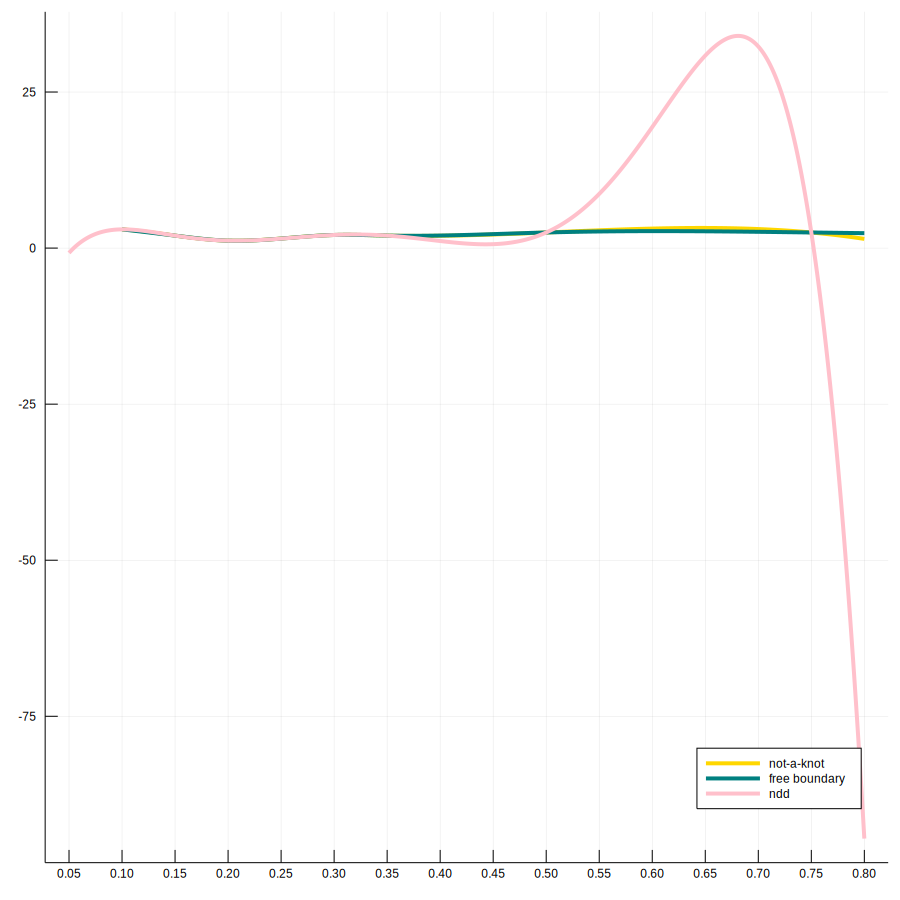

In [16]:
data = [(0.1,3.0), (0.15,2.0), (0.2, 1.2), (0.3, 2.1), (0.35, 2.0), (0.5, 2.5), (0.75, 2.5)]

np, = ndd(data=data)
nksplines = cspl(data=data, bc="nk")
fsplines = cspl(data=data, bc="free")

f0, f1, f2, f3, f4, f5 = fsplines
nk0, nk1, nk2, nk3, nk4, nk5 = nksplines

xx = collect(0.05:0.001:0.8)

x0 = collect(0.1:0.001:0.15)
x1 = collect(0.15:0.001:0.2)
x2 = collect(0.2:0.001:0.3)
x3 = collect(0.3:0.001:0.35)
x4 = collect(0.35:0.001:0.5)
x5 = collect(0.5:0.001:0.8)


p = plot([],[], xticks=0.05:0.05:0.8, label="", size=(900,900), legend=:bottomright)

plot!(p, x0, nk0.(x0), lc=:gold, lw=4, label="not-a-knot")
plot!(p, x1, nk1.(x1), lc=:gold, lw=4, label="")
plot!(p, x2, nk2.(x2), lc=:gold, lw=4, label="")
plot!(p, x3, nk3.(x3), lc=:gold, lw=4, label="")
plot!(p, x4, nk4.(x4), lc=:gold, lw=4, label="")
plot!(p, x5, nk5.(x5), lc=:gold, lw=4, label="")

plot!(p, x0, f0.(x0), lc=:teal, lw=4, label="free boundary")
plot!(p, x1, f1.(x1), lc=:teal, lw=4, label="")
plot!(p, x2, f2.(x2), lc=:teal, lw=4, label="")
plot!(p, x3, f3.(x3), lc=:teal, lw=4, label="")
plot!(p, x4, f4.(x4), lc=:teal, lw=4, label="")
plot!(p, x5, f5.(x5), lc=:teal, lw=4, label="")

plot!(p, xx, np.(xx), lc=:pink, lw=4, label="ndd")

# savefig(p, "7-point ndd")